In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from biom import load_table
from scipy.stats import ttest_rel, wilcoxon, ttest_ind, pearsonr, spearmanr
from skbio.stats.composition import multiplicative_replacement
import matplotlib.gridspec as gridspec

from collections import namedtuple

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

"""
Here, we have implemented an extended version of scipy's paired t-test function.
see https://github.com/scipy/scipy/blob/master/scipy/stats/mstats_basic.py#L1085

This should really be pushed to scipy -- any volunteers?
"""
import numpy as np
from scipy.stats import t
from scipy.special import betainc
from collections import namedtuple


Ttest_relResult = namedtuple('Ttest_relResult', 
                             ('statistic', 'pvalue', 'lower_CI', 'upper_CI', 'ddof'))


def ttest_rel(x, y):
    
    D = x - y
    n = len(D)
    
    sd = np.std(D, ddof=1) 
    se = sd / np.sqrt(n)
    mu = np.mean(D)
    T = mu / se
    ddof = n-1
    ci = se * t.ppf( 0.05 / 2, ddof) 
    lower = mu - np.abs(ci)
    upper = mu + np.abs(ci)
    
    prob = betainc(0.5*ddof, 0.5, ddof/(ddof + T*T))
    return Ttest_relResult(T, prob, lower, upper, int(ddof))


def paired_t_test(category, md, df):
    """ Performs paired t-test on a dataframe with complementing
    sample metadata.

    Parameters
    ----------
    category : str
       Category to test in the dataframe df
    md : pd.DataFrame
       Sample metadata specifying groupings
    df : pd.Dataframe
       Counts of microbes across all samples
              
    Returns
    -------
    T : float
       T-statistic
    prob : float
       p-value
    lower : float
       lower 95% CI bound
    upper : float
        upper 95% CI bound
    ddof : int
        degrees of freedom
    """
    cats = list(md[category].value_counts().index)
    src = md[md[category] == cats[0]].index
    print(src)
    dest = md[md[category] == cats[1]].index
    return ttest_rel(df.loc[dest].values, df.loc[src].values)

## Input Directory

In [9]:
input_dir = "/home/y1weng/02_evonik_batch2/songbird/evonik"

## Variables

In [4]:
syncom_strains = ["Corynebacterium afermentans",
    "Cutibacterium acnes",
    "Micrococcus luteus",
    "Staphylococcus aureus",
    "Staphylococcus capitis",
    "Staphylococcus epidermidis",
    "Staphylococcus hominis",
    "Staphylococcus warneri",
    "Streptococcus mitis"]

## SLES

Index(['post_left_sub1_S107_WoL_index_filtered',
       'post_left_sub10_S15_WoL_index_filtered',
       'post_left_sub12_S17_WoL_index_filtered',
       'post_left_sub13_S111_WoL_index_filtered'],
      dtype='object', name='sampleid')
Index(['post_left_sub1_S107_WoL_index_filtered',
       'post_left_sub10_S15_WoL_index_filtered',
       'post_left_sub12_S17_WoL_index_filtered',
       'post_left_sub13_S111_WoL_index_filtered'],
      dtype='object', name='sampleid')
Index(['post_left_sub1_S107_WoL_index_filtered',
       'post_left_sub10_S15_WoL_index_filtered',
       'post_left_sub12_S17_WoL_index_filtered',
       'post_left_sub13_S111_WoL_index_filtered'],
      dtype='object', name='sampleid')
Index(['post_left_sub1_S107_WoL_index_filtered',
       'post_left_sub10_S15_WoL_index_filtered',
       'post_left_sub12_S17_WoL_index_filtered',
       'post_left_sub13_S111_WoL_index_filtered'],
      dtype='object', name='sampleid')
Index(['post_left_sub1_S107_WoL_index_filtered',
   

,24hControl_vs_24hChemical_tstat,24hControl__vs_24hChemical_pvalue,24hControl_vs_24hChemical_upperCI,24hControl_vs_24hChemical_lowerCI
log(C.afermentans/S.mitis),0.535378,0.629533,-0.154266,0.216667
log(C.acnes/S.mitis),-1.333268,0.274644,-0.187545,0.076799
log(M.luteus/S.mitis),0.824717,0.469991,-0.696556,1.183857
log(S.aureus/S.mitis),1.182554,0.322172,-0.318472,0.695103
log(S.capitis/S.mitis),1.742379,0.179803,-0.513275,1.755328
log(S.epidermidis/S.mitis),2.918287,0.061581,-0.096608,2.231161
log(S.hominis/S.mitis),2.052143,0.132491,-0.197183,0.913181
log(S.warneri/S.mitis),1.221406,0.309161,-0.739553,1.660794


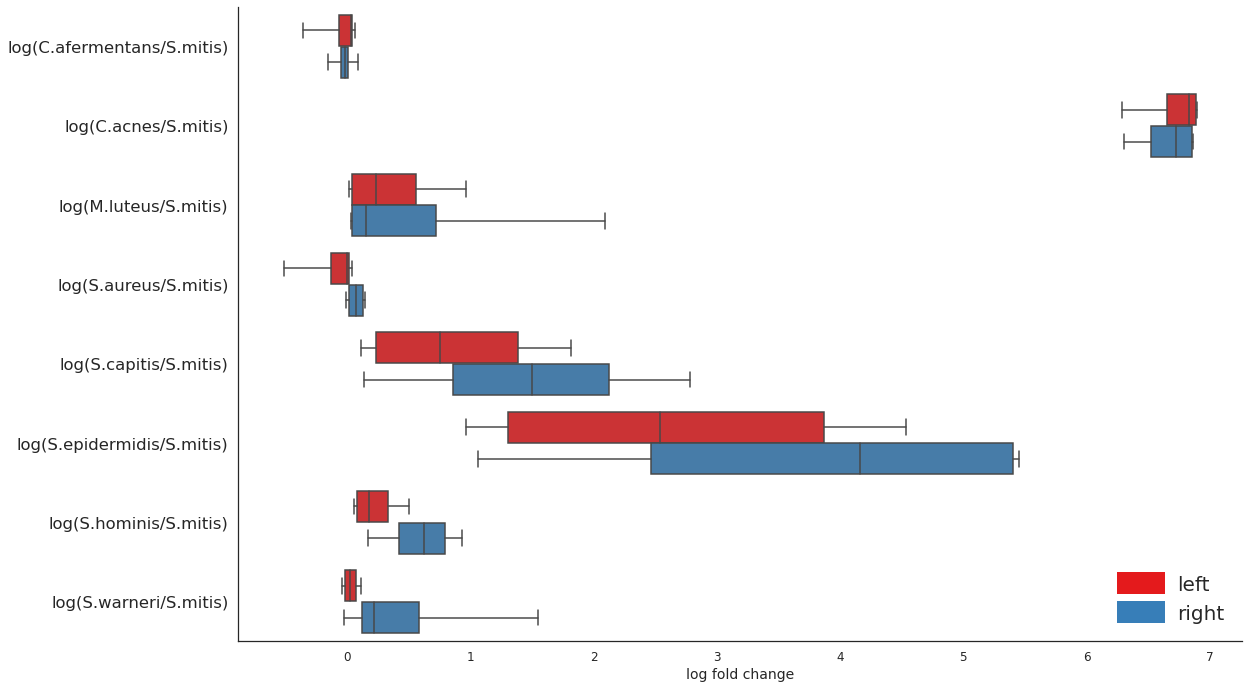

In [10]:
# load md
metadata = pd.read_table(f'{input_dir}/evonik_songbird_metadata.txt', index_col = 0)
metadata['chemical'] = np.where(metadata['Subject'].isin(['sub1', 'sub2', 'sub10', 'sub12', 'sub13']), 'SLES', 'RL')
metadata = metadata.sort_values('Subject')
metadata = metadata[(metadata['Time_Point'] == 'post') & (metadata['chemical'] == 'SLES') & (metadata['Subject'] != 'sub2')]

#load samples
table = load_table(f'{input_dir}/evonik_all_taxonomy_reformatted.biom').to_dataframe().T
table = table.loc[metadata.index.tolist(), syncom_strains]

# table normalization by column
table = table.loc[:, table.sum(axis=0)>0]
table = table.apply(lambda x: x / x.sum(), axis=1)

reference_species = 'Streptococcus mitis'

def balance_f(x):
    lr = [np.log(x['Corynebacterium afermentans']+0.001) - np.log(x[reference_species]+0.001),
          np.log(x['Cutibacterium acnes']+0.001) - np.log(x[reference_species]+0.001),
          np.log(x['Micrococcus luteus']+0.001) - np.log(x[reference_species]+0.001),
          np.log(x['Staphylococcus aureus']+0.001) - np.log(x[reference_species]+0.001),
          np.log(x['Staphylococcus capitis']+0.001) - np.log(x[reference_species]+0.001),
          np.log(x['Staphylococcus epidermidis']+0.001) - np.log(x[reference_species]+0.001),
          np.log(x['Staphylococcus hominis']+0.001) - np.log(x[reference_species]+0.001),
          np.log(x['Staphylococcus warneri']+0.001) - np.log(x[reference_species]+0.001),
         ]
    cols = [
        'log(C.afermentans/S.mitis)',
        'log(C.acnes/S.mitis)',
        'log(M.luteus/S.mitis)',
        'log(S.aureus/S.mitis)',
        'log(S.capitis/S.mitis)',
        'log(S.epidermidis/S.mitis)',
        'log(S.hominis/S.mitis)',
        'log(S.warneri/S.mitis)',
    ]
    return pd.Series(lr, index=cols)

balances = table.apply(balance_f, axis = 1)

f = lambda x: paired_t_test(category='Control', md=metadata, df=x)[0]
tstats = balances.apply(f, axis=0)

f = lambda x: paired_t_test(category='Control', md=metadata, df=x)[1]
tpvals = balances.apply(f, axis=0)

f = lambda x: paired_t_test(category='Control', md=metadata, df=x)[2]
tlower = balances.apply(f, axis=0)

f = lambda x: paired_t_test(category='Control', md=metadata, df=x)[3]
tupper = balances.apply(f, axis=0)

stats = pd.DataFrame(
    {
        '24hControl_vs_24hChemical_tstat': tstats,
        '24hControl__vs_24hChemical_pvalue': tpvals,
        '24hControl_vs_24hChemical_upperCI': tlower,
        '24hControl_vs_24hChemical_lowerCI': tupper
    }
)

data = pd.merge(balances, metadata, left_index=True, right_index=True)

subdata = data[[
    'log(C.afermentans/S.mitis)',
    'log(C.acnes/S.mitis)',
    'log(M.luteus/S.mitis)',
    'log(S.aureus/S.mitis)',
    'log(S.capitis/S.mitis)',
    'log(S.epidermidis/S.mitis)',
    'log(S.hominis/S.mitis)',
    'log(S.warneri/S.mitis)',
    'Control']]

df = pd.melt(subdata, id_vars = 'Control', var_name = 'balance')

# get the palette color name
deep_palette = sns.color_palette("Set1")

# Extract the first two colors
color1 = deep_palette[0]
color2 = deep_palette[1]

#, notch=True
sns.set(style="white", font_scale=1.5, font="sans-serif", palette="Set1")

# get a label for outlier,figure out why there is error bar 
# customize which counts as outlier
g = sns.catplot(x='value', y='balance', data=df, hue='Control', kind='box',
                hue_order=['left', 'right'], n_boot = 1000,
                height = 10, aspect = 1.8, legend = False, whis = [0,100])
g.set_xlabels('log fold change', fontsize=14)
g.set_ylabels('', fontsize=14)
plt.legend(fontsize = 20, frameon=False)
# plt.legend(loc='lower right', labels=['Control', 'Treatment'])
plt.legend(fontsize=20, frameon=False, loc='lower right')
plt.xticks(fontsize=12)

ax = plt.gca()
leg = ax.legend(fontsize=20, frameon=False, loc='lower right')
leg.legendHandles[0].set_linewidth(8)
leg.legendHandles[0].set_color(color1)
leg.legendHandles[1].set_linewidth(8)
leg.legendHandles[1].set_color(color2)
leg.get_frame().set_linewidth(0)
#plt.xticks(rotation=60)

# g.savefig('./out_sles/fig_sles.svg', format='svg')
stats.to_csv('day7_sles_stats.csv')
stats

# RL

In [14]:
# load md
metadata = pd.read_table(f'{input_dir}/evonik_songbird_metadata.txt', index_col = 0)
metadata['chemical'] = np.where(metadata['Subject'].isin(['sub1', 'sub2', 'sub10', 'sub12', 'sub13']), 'SLES', 'RL')
metadata = metadata.sort_values('Subject')
metadata = metadata[(metadata['Time_Point'] == 'post') & (metadata['chemical'] == 'RL') & (metadata['Subject'] != 'sub3') & (metadata['Subject'] != 'sub4') & (metadata['Subject'] != 'sub7')]

#load samples
table = load_table(f'{input_dir}/evonik_all_taxonomy_reformatted.biom').to_dataframe().T
table = table.loc[metadata.index.tolist(), syncom_strains]

Index(['post_left_sub11_S16_WoL_index_filtered',
       'post_left_sub5_S12_WoL_index_filtered',
       'post_left_sub6_S13_WoL_index_filtered',
       'post_left_sub8_S14_WoL_index_filtered',
       'post_left_sub9_S110_WoL_index_filtered'],
      dtype='object', name='sampleid')
Index(['post_left_sub11_S16_WoL_index_filtered',
       'post_left_sub5_S12_WoL_index_filtered',
       'post_left_sub6_S13_WoL_index_filtered',
       'post_left_sub8_S14_WoL_index_filtered',
       'post_left_sub9_S110_WoL_index_filtered'],
      dtype='object', name='sampleid')
Index(['post_left_sub11_S16_WoL_index_filtered',
       'post_left_sub5_S12_WoL_index_filtered',
       'post_left_sub6_S13_WoL_index_filtered',
       'post_left_sub8_S14_WoL_index_filtered',
       'post_left_sub9_S110_WoL_index_filtered'],
      dtype='object', name='sampleid')
Index(['post_left_sub11_S16_WoL_index_filtered',
       'post_left_sub5_S12_WoL_index_filtered',
       'post_left_sub6_S13_WoL_index_filtered',
       'p

,24hControl_vs_24hChemical_tstat,24hControl__vs_24hChemical_pvalue,24hControl_vs_24hChemical_upperCI,24hControl_vs_24hChemical_lowerCI
log(C.afermentans/S.mitis),1.047233,0.354098,-0.807928,1.786511
log(C.acnes/S.mitis),0.967290,0.388175,-0.874860,1.810372
log(M.luteus/S.mitis),0.769034,0.484766,-1.244916,2.198765
log(S.aureus/S.mitis),1.226869,0.287146,-0.666238,1.721219
log(S.capitis/S.mitis),1.826506,0.141802,-0.350454,1.698131
log(S.epidermidis/S.mitis),1.492913,0.209749,-0.553688,1.841707
log(S.hominis/S.mitis),0.741229,0.499711,-0.766247,1.324385
log(S.warneri/S.mitis),1.325931,0.255512,-0.716857,2.027432


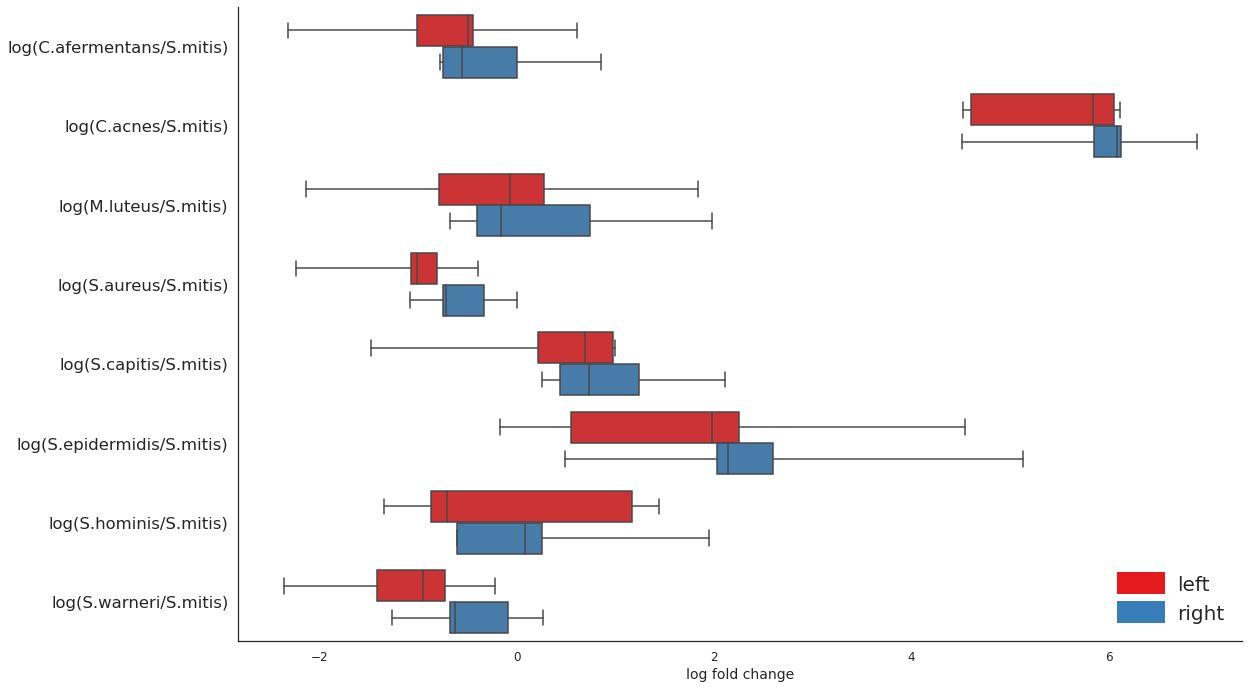

In [15]:
# table normalization by column
table = table.loc[:, table.sum(axis=0)>0]
table = table.apply(lambda x: x / x.sum(), axis=1)

reference_species = 'Streptococcus mitis'

def balance_f(x):
    lr = [np.log(x['Corynebacterium afermentans']+0.001) - np.log(x[reference_species]+0.001),
          np.log(x['Cutibacterium acnes']+0.001) - np.log(x[reference_species]+0.001),
          np.log(x['Micrococcus luteus']+0.001) - np.log(x[reference_species]+0.001),
          np.log(x['Staphylococcus aureus']+0.001) - np.log(x[reference_species]+0.001),
          np.log(x['Staphylococcus capitis']+0.001) - np.log(x[reference_species]+0.001),
          np.log(x['Staphylococcus epidermidis']+0.001) - np.log(x[reference_species]+0.001),
          np.log(x['Staphylococcus hominis']+0.001) - np.log(x[reference_species]+0.001),
          np.log(x['Staphylococcus warneri']+0.001) - np.log(x[reference_species]+0.001),
         ]
    cols = [
        'log(C.afermentans/S.mitis)',
        'log(C.acnes/S.mitis)',
        'log(M.luteus/S.mitis)',
        'log(S.aureus/S.mitis)',
        'log(S.capitis/S.mitis)',
        'log(S.epidermidis/S.mitis)',
        'log(S.hominis/S.mitis)',
        'log(S.warneri/S.mitis)',
    ]
    return pd.Series(lr, index=cols)

balances = table.apply(balance_f, axis = 1)

f = lambda x: paired_t_test(category='Control', md=metadata, df=x)[0]
tstats = balances.apply(f, axis=0)

f = lambda x: paired_t_test(category='Control', md=metadata, df=x)[1]
tpvals = balances.apply(f, axis=0)

f = lambda x: paired_t_test(category='Control', md=metadata, df=x)[2]
tlower = balances.apply(f, axis=0)

f = lambda x: paired_t_test(category='Control', md=metadata, df=x)[3]
tupper = balances.apply(f, axis=0)

stats = pd.DataFrame(
    {
        '24hControl_vs_24hChemical_tstat': tstats,
        '24hControl__vs_24hChemical_pvalue': tpvals,
        '24hControl_vs_24hChemical_upperCI': tlower,
        '24hControl_vs_24hChemical_lowerCI': tupper
    }
)

data = pd.merge(balances, metadata, left_index=True, right_index=True)

subdata = data[[
    'log(C.afermentans/S.mitis)',
    'log(C.acnes/S.mitis)',
    'log(M.luteus/S.mitis)',
    'log(S.aureus/S.mitis)',
    'log(S.capitis/S.mitis)',
    'log(S.epidermidis/S.mitis)',
    'log(S.hominis/S.mitis)',
    'log(S.warneri/S.mitis)',
    'Control']]

df = pd.melt(subdata, id_vars = 'Control', var_name = 'balance')

# get the palette color name
deep_palette = sns.color_palette("Set1")

# Extract the first two colors
color1 = deep_palette[0]
color2 = deep_palette[1]

#, notch=True
sns.set(style="white", font_scale=1.5, font="sans-serif", palette="Set1")

# get a label for outlier,figure out why there is error bar 
# customize which counts as outlier
g = sns.catplot(x='value', y='balance', data=df, hue='Control', kind='box',
                hue_order=['left', 'right'], n_boot = 1000,
                height = 10, aspect = 1.8, legend = False, whis = [0,100])
g.set_xlabels('log fold change', fontsize=14)
g.set_ylabels('', fontsize=14)
plt.legend(fontsize = 20, frameon=False)
# plt.legend(loc='lower right', labels=['Control', 'Treatment'])
plt.legend(fontsize=20, frameon=False, loc='lower right')
plt.xticks(fontsize=12)

ax = plt.gca()
leg = ax.legend(fontsize=20, frameon=False, loc='lower right')
leg.legendHandles[0].set_linewidth(8)
leg.legendHandles[0].set_color(color1)
leg.legendHandles[1].set_linewidth(8)
leg.legendHandles[1].set_color(color2)
leg.get_frame().set_linewidth(0)
#plt.xticks(rotation=60)

# g.savefig('./out_sles/fig_sles.svg', format='svg')
stats.to_csv('day7_rl_stats.csv')
stats